In [85]:
import scipy.ndimage
import rasterio
import skimage.morphology
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import random
from rasterio.windows import Window
import time
from pyapril.caCfar import CA_CFAR

(194, 260)

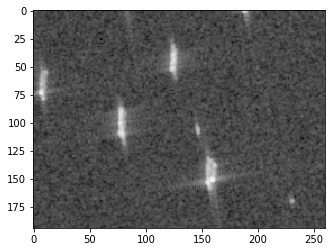

In [60]:
# Read image and raster
src = rasterio.open("data/test_data.tif")
array = src.read(1)

plt.imshow(array,cmap="gray")
array.shape

## Crop Image
Source: https://gis.stackexchange.com/questions/367832/using-rasterio-to-crop-image-using-pixel-coordinates-instead-of-geographic-coord   
adapted to take top righ corner

In [61]:
with rasterio.open('data/test_data.tif') as src:
    
    # The size in pixels of your desired window
    xsize, ysize = 190, 190

    # Generate a random window location that doesn't go outside the image
    xmin, xmax = 0, src.width - xsize
    ymin, ymax = 0, src.height - ysize
    #xoff, yoff = random.randint(xmin, xmax), random.randint(ymin, ymax)
    xoff, yoff = 0, 0

    # Create a Window and calculate the transform from the source dataset    
    window = Window(xoff, yoff, xsize, ysize)
    transform = src.window_transform(window)

    # Create a new cropped raster to write to
    profile = src.profile
    profile.update({
        'height': xsize,
        'width': ysize,
        'transform': transform})

    with rasterio.open('data/test_data_crop.tif', 'w', **profile) as dst:
        # Read the data from the window and write it to the output raster
        dst.write(src.read(window=window))

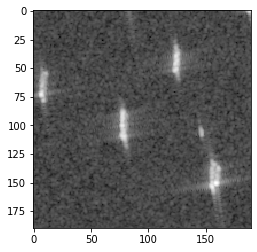

In [62]:
# Read image and raster
src = rasterio.open("data/test_data_crop.tif")
array = src.read(1)

plt.imshow(array,cmap="gray")

In [75]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

## CFAR
Source: https://github.com/petotamas/APRiL/blob/master/testing/caCfarTest.py  

Unfortuantely I could not adapt the CFAR algorithm to fit the test data in this case. 

In [86]:


"""
Test CA_CFAR implementation and compare variants.
 """


def CA_CFAR_naive(rd_matrix, win_param, threshold):
    # -- Set inital parameters --
    win_len = win_param[0]
    win_width = win_param[1]
    guard_len = win_param[2]
    guard_width = win_param[3]

    norc = np.size(rd_matrix, 1)  # number of range cells
    noDc = np.size(rd_matrix, 0)  # number of Doppler cells
    hit_matrix = np.zeros((noDc, norc), dtype=float)

    # Convert range-Doppler map values to power
    rd_matrix = np.abs(rd_matrix) ** 2

    # Generate window mask
    rd_block = np.zeros((2 * win_width + 1, 2 * win_len + 1), dtype=float)
    mask = np.ones((2 * win_width + 1, 2 * win_len + 1))
    mask[win_width - guard_width:win_width + 1 + guard_width, win_len - guard_len:win_len + 1 + guard_len] = np.zeros(
        (guard_width * 2 + 1, guard_len * 2 + 1))

    cell_counter = np.sum(mask)

    # Convert threshold value
    threshold = 10 ** (threshold / 10)
    threshold /= cell_counter

    # -- Perform automatic detection --
    for j in np.arange(win_width, noDc - win_width, 1):  # Range loop
        for i in np.arange(win_len, norc - win_len, 1):  # Doppler loop
            rd_block = rd_matrix[j - win_width:j + win_width + 1, i - win_len:i + win_len + 1]
            rd_block = np.multiply(rd_block, mask)
            cell_SINR = rd_matrix[j, i] / np.sum(rd_block) # esimtate CUT SINR

            # Hard decision
            if cell_SINR > threshold:
                hit_matrix[j, i] = 1

    return hit_matrix


def CA_CFAR_naive_with_edge_treatment(rd_matrix, win_param, threshold):
    # -- Set inital parameters --
    win_width = win_param[0]
    win_height = win_param[1]
    guard_width = win_param[2]
    guard_height = win_param[3]

    num_range_cells = np.size(rd_matrix, 1)
    num_doppler_cells = np.size(rd_matrix, 0)

    hit_matrix = np.zeros((num_range_cells, num_doppler_cells), dtype=float)
    # Convert range-Doppler map values to power
    rd_matrix = np.abs(rd_matrix) ** 2

    # Create window mask
    mask = np.ones((2 * win_height + 1, 2 * win_width + 1), dtype=bool)
    mask[win_height - guard_height:win_height + 1 + guard_height, win_width - guard_width:win_width + 1 + guard_width] = 0

    # Convert threshold value
    threshold = 10 ** (threshold / 10)

    # Perform detection
    for cut_row in np.arange(num_range_cells):  # Range loop
        for cut_col in np.arange(num_doppler_cells):  # Doppler loop
            # edge treatment: use only values within the rd map
            win_row_min = max(0, cut_row - win_height)
            win_row_max = min(cut_row + win_height, num_range_cells - 1)
            win_col_min = max(0, cut_col - win_width)
            win_col_max = min(cut_col + win_width, num_doppler_cells - 1)

            win_row_min_diff = np.abs(win_row_min - (cut_row - win_height))
            win_row_max_diff = np.abs(win_row_max - (cut_row + win_height))
            win_col_min_diff = np.abs(win_col_min - (cut_col - win_width))
            win_col_max_diff = np.abs(win_col_max - (cut_col + win_width))

            rd_block = rd_matrix[win_row_min:win_row_max+1, win_col_min: win_col_max+1]
            current_mask = mask[win_row_min_diff:mask.shape[0]-win_row_max_diff, win_col_min_diff: mask.shape[1]-win_col_max_diff]
            rd_block = rd_block[current_mask]
            cut_SINR = rd_matrix[cut_row, cut_col] / np.average(rd_block)

            # Hard decision
            if cut_SINR > threshold:
                hit_matrix[cut_row, cut_col] = 1

    return hit_matrix

# define dummy test data
#rd_map = np.load("data/rd_map.npy")
rd_map = array
params = [10, 2, 1, 1]
threshold = 2

# Naive ca-cfar implementation
start_t = time.time()
hit_matrix_naive = CA_CFAR_naive(rd_map, params, threshold)
duration_naive = time.time() - start_t

# Naive ca-cfar implementation with edge treatment
start_t = time.time()
hit_matrix_naive_with_edges = CA_CFAR_naive_with_edge_treatment(rd_map, params, threshold)
duration_naive_edge = time.time() - start_t

# Faster ca-cfar implementation with edge treatment using a convolution
start_t = time.time()
ca_cfar_obj = CA_CFAR(params, threshold, rd_map.shape)
duration_fast_obj = time.time() - start_t

start_t = time.time()
hit_matrix_fast_from_instance = ca_cfar_obj(rd_map)
duration_fast_call = time.time() - start_t

# Verify, that hit_matrix_naive and hit_matrix_naive_with_edges is the same except for the edges
assert(np.all(hit_matrix_naive[params[1]:-params[1], params[0]: -params[0]] == hit_matrix_naive_with_edges[params[1]:-params[1], params[0]: -params[0]]))

# Verify, that hit_matrix_naive_with_edges, hit_matrix_fast_from_function and hit_matrix_fast_from_instance are the same
assert(np.all(hit_matrix_naive_with_edges == hit_matrix_fast_from_instance))

"""
print("\nImplementations OK.\n")

print("++ Run times ++")
print("Naive: {:2.4f}".format(duration_naive))
print("Naive with edge treatment: {:2.4f}".format(duration_naive_edge))
print("Fast (object creation): {:2.4f}".format(duration_fast_obj))
print("Fast (object call): {:2.4f}".format(duration_fast_call))
print("Fast (object creation+call): {:2.4f}".format(duration_fast_obj+duration_fast_call))
"""

'\nprint("\nImplementations OK.\n")\n\nprint("++ Run times ++")\nprint("Naive: {:2.4f}".format(duration_naive))\nprint("Naive with edge treatment: {:2.4f}".format(duration_naive_edge))\nprint("Fast (object creation): {:2.4f}".format(duration_fast_obj))\nprint("Fast (object call): {:2.4f}".format(duration_fast_call))\nprint("Fast (object creation+call): {:2.4f}".format(duration_fast_obj+duration_fast_call))\n'

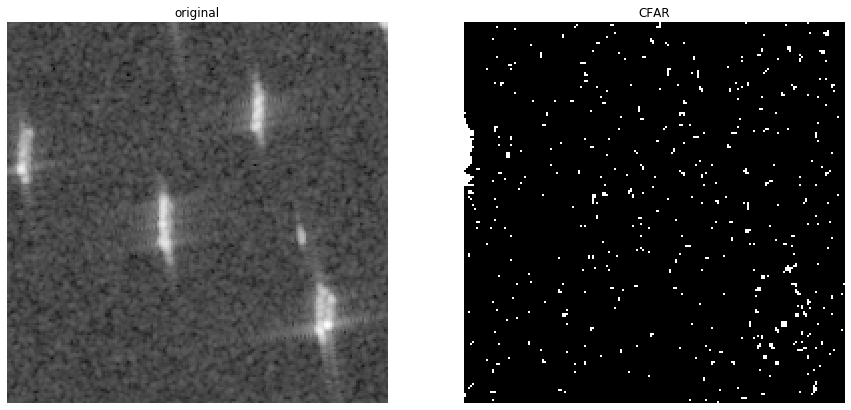

In [87]:
plot_comparison(rd_map, hit_matrix_fast_from_instance, "CFAR")

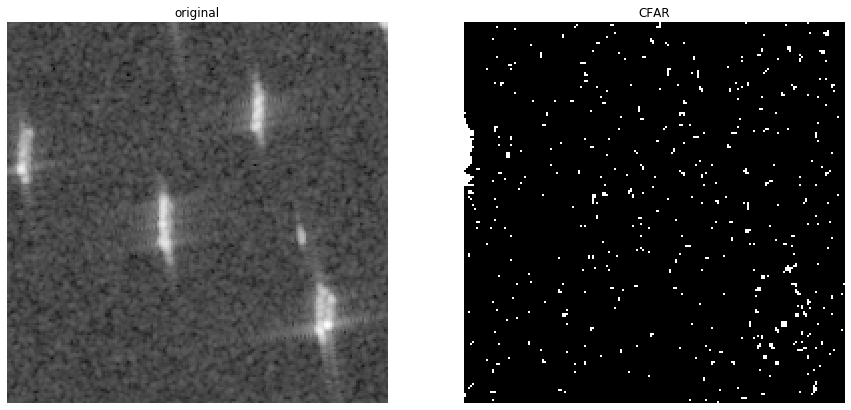

In [88]:
plot_comparison(array, hit_matrix_naive_with_edges, "CFAR")